In [1]:
import numpy as np 
import pandas as pd

In [2]:
# Comment out when running in kaggle

# INDEX = 'usedCarSkuId'
# TARGET = 'listed_price'
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# df = pd.read_csv('/kaggle/input/transformed-data/transformed.csv', index_col=INDEX)

In [3]:
# While running locally
from src.utils.data_loader import DataLoader
from src.feature_engineering.feature_transformations import FeatureEngineeringTransformations
from src.utils.constants import *
import os
from src.model_selection.load_data import load_train_test_valid_data

train, test, valid = load_train_test_valid_data(
	train_path='../data/train/train_2023-04-06_14-02-36.csv',
	test_path='../data/test/test_2023-04-06_14-02-38.csv',
	validation_path='../data/validation/validation_2023-04-06_14-02-39.csv',
)
train.shape, test.shape, valid.shape


Reading training file from : ../data/train/train_2023-04-06_14-02-36.csv
<class 'pandas.core.frame.DataFrame'>
Index: 28808 entries, eaa36396-cd6c-4a4e-9f85-57669077d9a0 to be462430-1815-43b9-9f15-11c5a024bd22
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   myear                 28808 non-null  int64  
 1   body                  28792 non-null  object 
 2   transmission          28808 non-null  object 
 3   fuel                  28808 non-null  object 
 4   km_driven             28808 non-null  int64  
 5   ip                    28808 non-null  int64  
 6   oem                   28808 non-null  object 
 7   model                 28808 non-null  object 
 8   variant               28808 non-null  object 
 9   City                  28808 non-null  object 
 10  listed_price          28808 non-null  float64
 11  utype                 28808 non-null  object 
 12  top_features          28808 non-null  

((28808, 49), (5084, 49), (3766, 49))

---

# Feature Engineering

*Only required when running this notebook in kaggle or without the repository*

In [4]:
# from sklearn.base import BaseEstimator
# from ast import literal_eval
#
#
# class FeatureEngineeringTransformations(BaseEstimator):
#     """
#     This class contains all the recommended feature engineering transformations for the dataset.
#
#     :parameter
#         df: pd.DataFrame
#             The dataframe to be transformed
#         object_cols: list
#             The list of columns that contain the car features like top_features, comfort_features, etc. that need to be transformed
#     """
#
#     def __init__(
#             self,
#             df: pd.DataFrame,
#             object_cols=None
#     ):
#         if object_cols is None:
#             object_cols = [
#                 'top_features',
#                 'comfort_features',
#                 'interior_features',
#                 'exterior_features',
#                 'safety_features'
#             ]
#         self.df = df.copy()
#         self.object_cols = object_cols
#         self.feature_prices = None
#         self.is_fitted = False
#
#     def _car_object_feature_dict(self) -> dict:
#         unique_feature_scores = dict()
#         for col in self.object_cols:
#             for _, row in self.df.iterrows():
#                 feature_list = literal_eval(row[col])
#                 for feature in feature_list:
#                     if feature in unique_feature_scores.keys():
#                         unique_feature_scores[feature][1] += 1
#                         unique_feature_scores[feature][0] += row[TARGET]
#                     else:
#                         unique_feature_scores[feature] = [row[TARGET], 1]
#
#         return unique_feature_scores
#
#     def _map_object_cols_to_scores(self, x: str) -> float:
#         feature_list = literal_eval(x)
#         feature_score = 0
#         for feature in feature_list:
#             if feature in self.feature_prices.keys():
#                 feature_score += self.feature_prices[feature][0] / self.feature_prices[feature][1]
#             else:
#                 feature_score += 0
#         return feature_score
#
#     def _car_object_feature_transformation(self, df) -> pd.DataFrame:
#         if self.feature_prices is None:
#             raise Exception('Please fit the transformer first')
#
#         for col in self.object_cols:
#             df[f'{col}_score'] = df[col].apply(self._map_object_cols_to_scores)
#             df.drop(col, axis=1, inplace=True)
#             # Replace zero scores with nan
#             df[f'{col}_score'] = df[f'{col}_score'].replace(0, np.nan)
#         return df
#
#     def fit(self, X=None, y=None):
#         self.feature_prices = self._car_object_feature_dict()
#         self.df = self._car_object_feature_transformation(self.df)
#         self.is_fitted = True
#         return self
#
#     def transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         if not self.is_fitted:
#             raise Exception('Please fit the transformer first')
#
#         df = df.copy()
#         # Transform the object columns to scores
#         df = self._car_object_feature_transformation(df)
#         return df

---

# Training and Testing Data

In [5]:
# train, test, valid = get_training_testing_validation_data(df)

# Do the feature engineering transformations
# fe = FeatureEngineeringTransformations(train)
# fe = fe.fit()
#
# train = fe.transform(train)
# test = fe.transform(test)
# valid = fe.transform(valid)

train.shape, test.shape, valid.shape

((28808, 49), (5084, 49), (3766, 49))

In [6]:
X_train = train.drop(columns=[TARGET], axis=1).reset_index(drop=True)
y_train = train[TARGET].reset_index(drop=True)
X_test = test.drop(columns=[TARGET], axis=1).reset_index(drop=True)
y_test = test[TARGET].reset_index(drop=True)

---

# Pre Processor

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from src.feature_engineering.imputations import MatchingImputerArguments, CustomMatchingImputer

set_config(transform_output = "pandas")

## Feature Engineering

In [8]:
feature_engineering = FeatureEngineeringTransformations(target=TARGET)
replace_col_scores = feature_engineering.object_cols
replacement_col_scores = [f'{col}_score' for col in replace_col_scores]

## Feature Scaling and encoding

In [17]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
y_train_cat = y_train.copy()
y_test_cat = y_test.copy()

cat_categorical_cols = [col for col in X_train_cat.select_dtypes(include=['category', 'object']).columns if col not in replace_col_scores]
cat_numerical_cols = [col for col in X_train_cat.columns if col not in  cat_categorical_cols and col not in replace_col_scores]
cat_numerical_cols.extend(replacement_col_scores)

categorical_cols_with_nan = [col for col in cat_categorical_cols if X_train_cat[col].isnull().any()]
X_train_cat[cat_categorical_cols] = X_train_cat[cat_categorical_cols].astype('category')
X_train_cat[cat_categorical_cols] = X_train_cat[cat_categorical_cols].astype('category')

# Also set the transformed column names once they come out of the pipeline
cat_categorical_cols_trans = [f'cat__{col}' for col in cat_categorical_cols]
cat_numerical_cols_trans = [f'num__{col}' for col in cat_numerical_cols]

numerical_transformer = Pipeline([
	('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
	('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
])

mathing_imputer = Pipeline([
    ('matching_imputer', CustomMatchingImputer())
])

column_transformer = ColumnTransformer([
	# ('matching', mathing_imputer, X_train.columns.to_list()),
	('num', numerical_transformer, cat_numerical_cols),
	('cat', categorical_transformer, cat_categorical_cols)
])

In [18]:
# X_train_cat = feature_engineering.fit_transform(X_train_cat, y_train_cat)
# X_test_cat = feature_engineering.transform(X_test_cat)

preprocessor = Pipeline([
	('feature_engineering', feature_engineering),
	('column_transformer', column_transformer),
])

In [11]:
# # Catboost doesn't work very well with the sklearn pipeline
#
# # We will preprocess the data separately and then feed it to the model
# X_train_cat = feature_engineering.fit_transform(X_train_cat, y_train_cat)
# X_test_cat = feature_engineering.transform(X_test_cat)
# X_train_cat = column_transformer.fit_transform(X_train_cat)
# X_test_cat = column_transformer.transform(X_test_cat)

---

# Model

In [13]:
from sklearn.model_selection import train_test_split
import catboost

class CustomCatBoostRegressor(catboost.CatBoostRegressor):
    def __init__(self, transformed=False, preprocessor=None, **kwargs):
        super().__init__(**kwargs)
        self.preprocessor = preprocessor
        self.transformed_target_function = np.log
        self.inverse_transformed_target_function = np.exp
        self.transformed = transformed

    # Modify the fit and predict methods to work with the sklearn pipeline
    def fit(self, X, y, eval=True, eval_size=0.1, plot=True, **kwargs):
        X = X.copy()
        y = y.copy()

        if self.transformed:
            y = self.transformed_target_function(y)

        if self.preprocessor:
            X = preprocessor.fit_transform(X, y)

        # Get the categorical columns
        cat_features = [col for col in X.select_dtypes(include=['category', 'object']).columns]
        if eval:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=eval_size, random_state=42)
            pool_train = catboost.Pool(X_train, y_train, cat_features=cat_features)
            pool_test = catboost.Pool(X_test, y_test, cat_features=cat_features)
            return super().fit(pool_train, eval_set=(pool_test), plot=plot, **kwargs)
        else:
            pool_train = catboost.Pool(X, y, cat_features=cat_features)
            return super().fit(pool_train, plot=plot, **kwargs)

    def predict(self, X, **kwargs):
        X = X.copy()
        if self.preprocessor:
            X = self.preprocessor.transform(X)
        cat_features = [col for col in X.select_dtypes(include=['category', 'object']).columns]
        pool_test = catboost.Pool(X, cat_features=cat_features)
        if not self.transformed:
            return super().predict(pool_test, **kwargs)
        else:
            return self.inverse_transformed_target_function(super().predict(pool_test, **kwargs))

In [32]:
cb_model = CustomCatBoostRegressor(
    preprocessor=preprocessor,
	learning_rate = 0.06,
	depth = 5,
	l2_leaf_reg = 4,
	loss_function = 'MAPE',
	bootstrap_type = 'Bernoulli',
	subsample = 0.5,
	random_seed = 42,
	allow_writing_files = False,
	verbose = 100,
	n_estimators = 10000,
	early_stopping_rounds=100,
    transformed=True,
)

In [33]:
cb_model.fit(
    X_train_cat,
    y_train_cat,
    eval=True,
    eval_size=0.1,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0458501	test: 0.0458748	best: 0.0458748 (0)	total: 160ms	remaining: 26m 42s
100:	learn: 0.0116576	test: 0.0116022	best: 0.0116022 (100)	total: 2.49s	remaining: 4m 4s
200:	learn: 0.0101277	test: 0.0102467	best: 0.0102467 (200)	total: 4.56s	remaining: 3m 42s
300:	learn: 0.0094226	test: 0.0096532	best: 0.0096532 (300)	total: 6.75s	remaining: 3m 37s
400:	learn: 0.0090077	test: 0.0093021	best: 0.0093021 (400)	total: 9.15s	remaining: 3m 39s
500:	learn: 0.0087477	test: 0.0091104	best: 0.0091104 (500)	total: 11.5s	remaining: 3m 38s
600:	learn: 0.0085604	test: 0.0089756	best: 0.0089756 (600)	total: 13.6s	remaining: 3m 32s
700:	learn: 0.0084127	test: 0.0088857	best: 0.0088852 (698)	total: 16.3s	remaining: 3m 36s
800:	learn: 0.0082865	test: 0.0088165	best: 0.0088163 (799)	total: 18.8s	remaining: 3m 36s
900:	learn: 0.0081823	test: 0.0087432	best: 0.0087432 (900)	total: 21.5s	remaining: 3m 37s
1000:	learn: 0.0080946	test: 0.0087061	best: 0.0087059 (997)	total: 23.8s	remaining: 3m 34s
11

In [39]:
X_test_cat.select_dtypes(include=['float64', 'int64'])

,myear,km_driven,ip,Displacement,No of Cylinder,Valves per Cylinder,Width,Wheel Base,Front Tread,Kerb Weight,...,Top Speed,Acceleration,Doors,Cargo Volume,mileage_new,Alloy Wheel Size,Max Power Delivered,Max Power At,Max Torque Delivered,Max Torque At
0,2020,22472,0,1197.0,4.0,4.0,1745.0,2520.0,1505.0,865.0,...,NaN,12.36,4.0,339.0,21.01,NaN,81.80,6000.0,113.0,4200.0
1,2020,20000,0,2179.0,4.0,4.0,1890.0,2700.0,1600.0,NaN,...,NaN,NaN,4.0,NaN,15.10,17.0,152.87,3750.0,360.0,2275.0
2,2013,90000,0,1199.0,4.0,4.0,1595.0,2375.0,NaN,NaN,...,NaN,NaN,4.0,170.0,18.60,14.0,79.40,6200.0,108.0,4400.0
3,2017,36751,0,1498.0,4.0,4.0,1695.0,2600.0,1480.0,1165.0,...,175.0,10.00,4.0,510.0,26.00,15.0,98.60,3600.0,200.0,1750.0
4,2012,133050,0,1248.0,4.0,4.0,1687.0,2510.0,NaN,1130.0,...,NaN,NaN,4.0,280.0,20.30,14.0,75.00,4000.0,197.0,1750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,2019,15000,0,1498.0,4.0,4.0,1765.0,2519.0,NaN,1261.0,...,NaN,NaN,4.0,352.0,23.00,NaN,98.96,3750.0,205.0,2500.0
5080,2021,16000,0,999.0,3.0,4.0,1579.0,2422.0,NaN,NaN,...,NaN,16.00,4.0,279.0,22.00,NaN,67.00,5500.0,91.0,4250.0
5081,2017,21100,0,1197.0,4.0,4.0,1735.0,2450.0,1530.0,860.0,...,NaN,12.60,4.0,378.0,21.21,NaN,81.80,6000.0,113.0,4200.0
5082,2016,53804,0,1498.0,4.0,4.0,1680.0,2405.0,NaN,1055.0,...,170.0,17.00,4.0,400.0,25.80,NaN,98.60,3600.0,200.0,1750.0


In [41]:
# Use shap to explain the model
import shap

# Create a shap explainer
explainer = shap.TreeExplainer(cb_model)

# Calculate the shap values only for the numeric features
pool_shap_test =  catboost.Pool(X_test_cat.select_dtypes(include=['float64', 'int64']), y_test_cat, cat_features=None)
shap_values_numeric = explainer.shap_values(pool_shap_test)

# Plot the shap values
shap.summary_plot(shap_values_numeric, pool_shap_test, plot_type='bar')

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name num__myear (found myear).

In [42]:
from catboost import Pool

preprocessor = preprocessor.fit(X_train_cat, y_train_cat)
X_test_trans = preprocessor.transform(X_test_cat)
pool_shap_test = catboost.Pool(X_test_trans, y_test_cat, cat_features=cat_categorical_cols_trans)

shap_values = cb_model.get_feature_importance(pool_shap_test, type="ShapValues")

expected_value = shap_values[0,-1]
shap_value = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_value[0,:], X_test.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


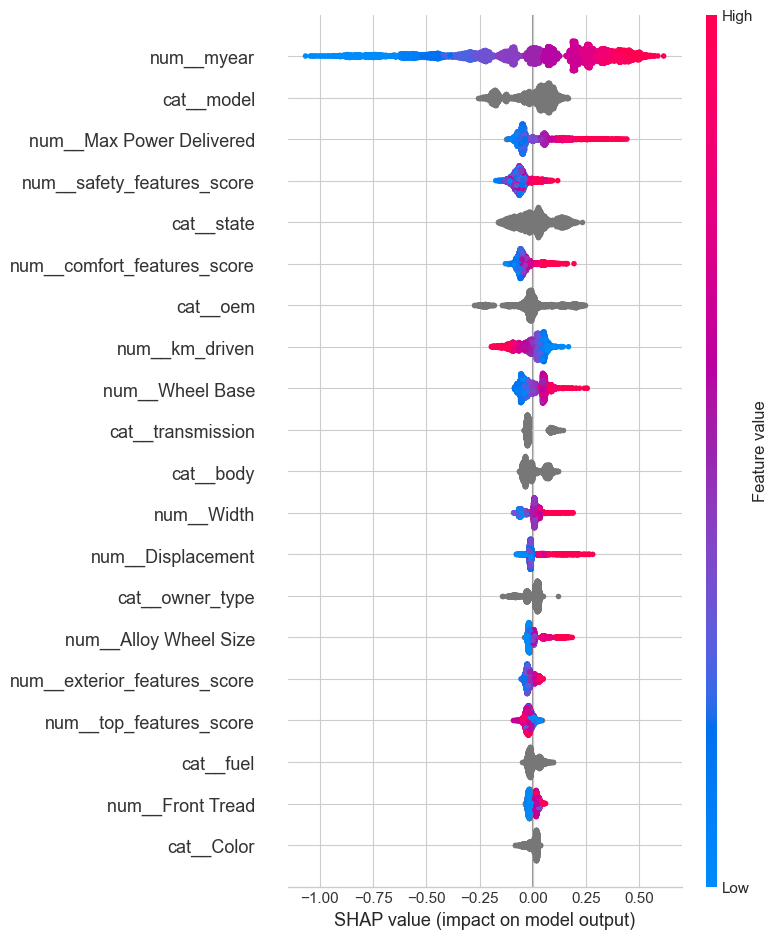

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(20, 40))
shap.summary_plot(shap_values[:,:-1], X_test_trans)
# Change the figure size
fig.set_size_inches(20, 40)

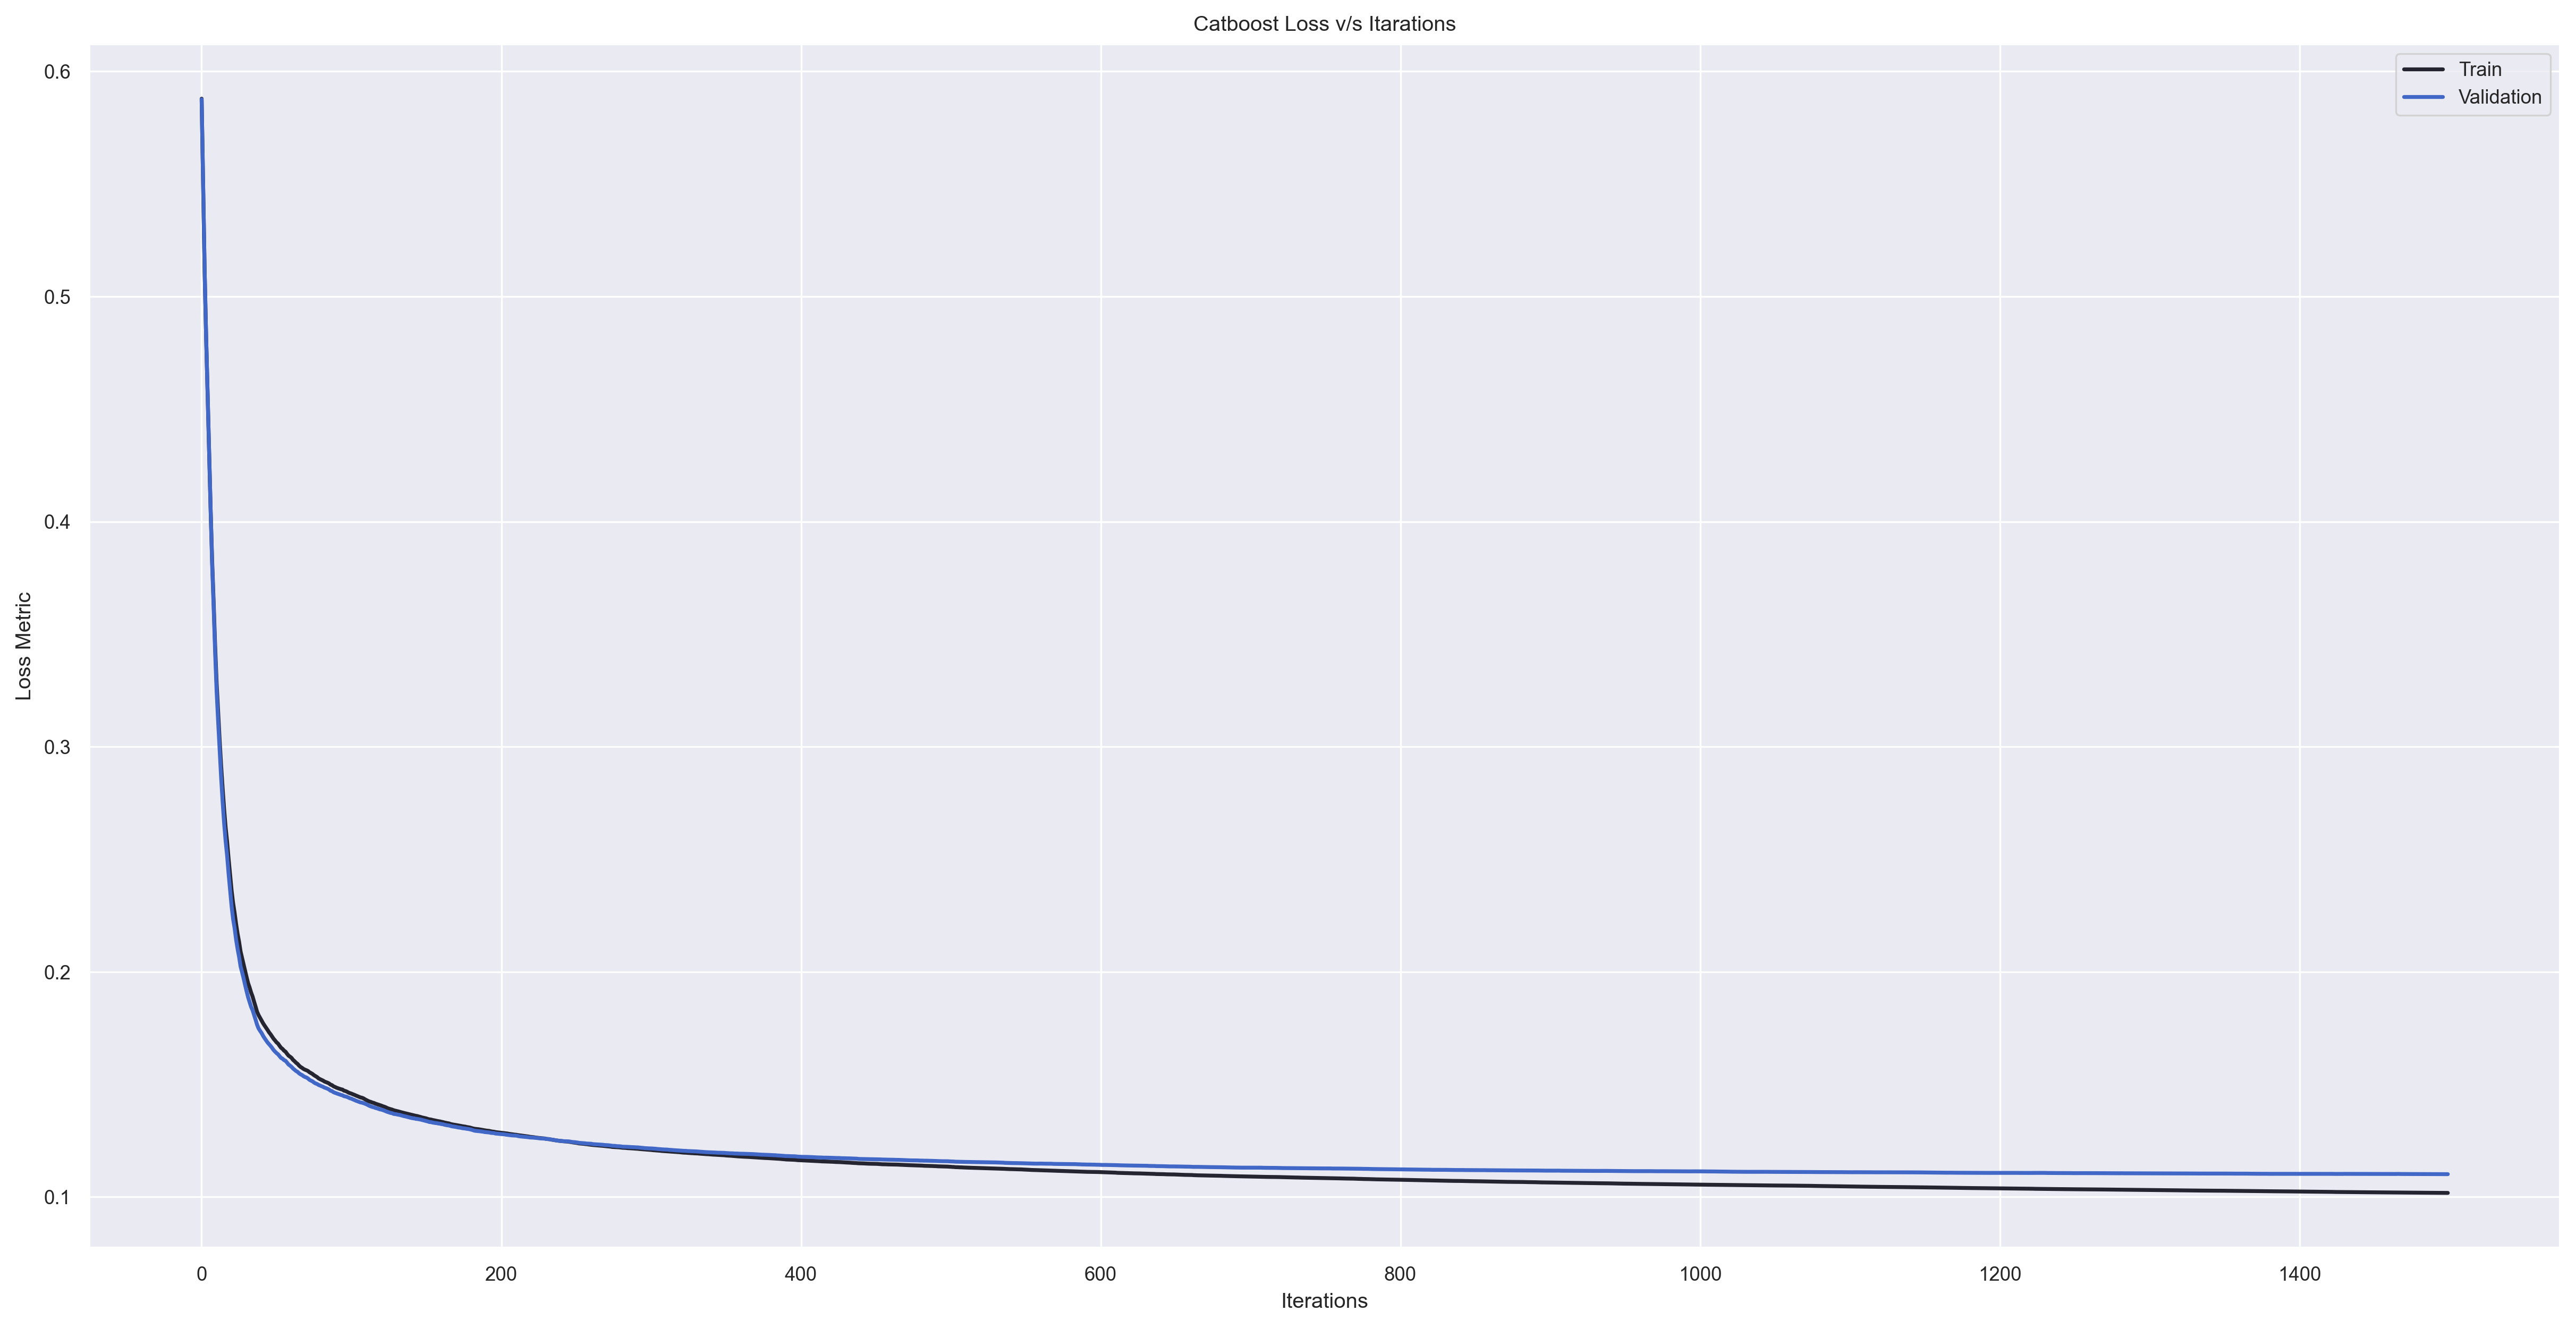

In [52]:
import random
from matplotlib import pyplot as plt
import seaborn as sns

def plot_learning_curve(cb_model, loss):
	sns.set_style('darkgrid')
	sns.set_context('paper', font_scale=1)
	plt.rcParams['figure.dpi'] = 300
	fig, ax = plt.subplots(1, 1, figsize=(20, 10))

	pallete = sns.color_palette("icefire", 15)
	color1 = random.choice(pallete)
	color2 = random.choice(pallete)

	plot = sns.lineplot(cb_model.evals_result_['learn'][loss], label='Train', linewidth=1.75, color=color1)
	plot = sns.lineplot(cb_model.evals_result_['validation'][loss], label='Validation', linewidth=1.75, color=color2)
	# plot.set_ylim([40000, 2e5])
	plot.set_xlabel('Iterations')
	plot.set_ylabel('Loss Metric')
	plot.set_title('Catboost Loss v/s Itarations')
	plt.show()

plot_learning_curve(cb_model, 'MAE')

In [53]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
# Make predictions on the test data
y_pred = cb_model.predict(X_test_cat)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test_cat, y_pred)
mae = mean_absolute_error(y_test_cat, y_pred)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MAPE: 0.10990885629755127
MAE: 79323.94044181821


In [248]:
residuals = abs(y_test_cat-y_pred)
residuals_percent = residuals/y_test_cat
residuals_percent.describe()

count    3390.000000
mean        0.119119
std         0.149803
min         0.000243
25%         0.037243
50%         0.079332
75%         0.149346
max         2.765278
Name: listed_price, dtype: float64

In [253]:
print(f'25% of the residuals are less than {residuals_percent.quantile(0.25)}')
print(f'50% of the residuals are less than {residuals_percent.quantile(0.5)}')
print(f'75% of the residuals are less than {residuals_percent.quantile(0.75)}')
print(f'90% of the residuals are less than {residuals_percent.quantile(0.9)}')
print(f'95% of the residuals are less than {residuals_percent.quantile(0.95)}')
print(f'99% of the residuals are less than {residuals_percent.quantile(0.99)}')

25% of the residuals are less than 0.03724259208752191
50% of the residuals are less than 0.07933191583676188
75% of the residuals are less than 0.1493456861521078
90% of the residuals are less than 0.25629645152565644
95% of the residuals are less than 0.3529343709599199
99% of the residuals are less than 0.6480365463587033


In [259]:
print(f'25% of the prices are less than {y_train_cat.quantile(0.25)}')
print(f'50% of the prices are less than {y_train_cat.quantile(0.5)}')
print(f'75% of the prices are less than {y_train_cat.quantile(0.75)}')
print(f'90% of the prices are less than {y_train_cat.quantile(0.9)}')
print(f'95% of the prices are less than {y_train_cat.quantile(0.95)}')
print(f'99% of the prices are less than {y_train_cat.quantile(0.99)}')

25% of the prices are less than 320000.0
50% of the prices are less than 525000.0
75% of the prices are less than 860000.0
90% of the prices are less than 1550000.0
95% of the prices are less than 2150000.0
99% of the prices are less than 4850000.0


In [273]:
# Aggregate the cars by their oem and have the following info:
# Mean price
# 25% price
# 50% price
# 75% price
# 90% price
# 95% price

df_oem_agg = df.groupby('oem').agg({
    TARGET: ['mean',  pd.Series.quantile(q=[.25, .5, .75])]
})
df_oem_agg

TypeError: Series.quantile() missing 1 required positional argument: 'self'

In [276]:
df[TARGET].describe()

count    3.765800e+04
mean     7.802705e+05
std      9.445158e+05
min      1.196300e+04
25%      3.200000e+05
50%      5.260000e+05
75%      8.600000e+05
max      1.976873e+07
Name: listed_price, dtype: float64

Text(0, 0.5, 'Error percentage')

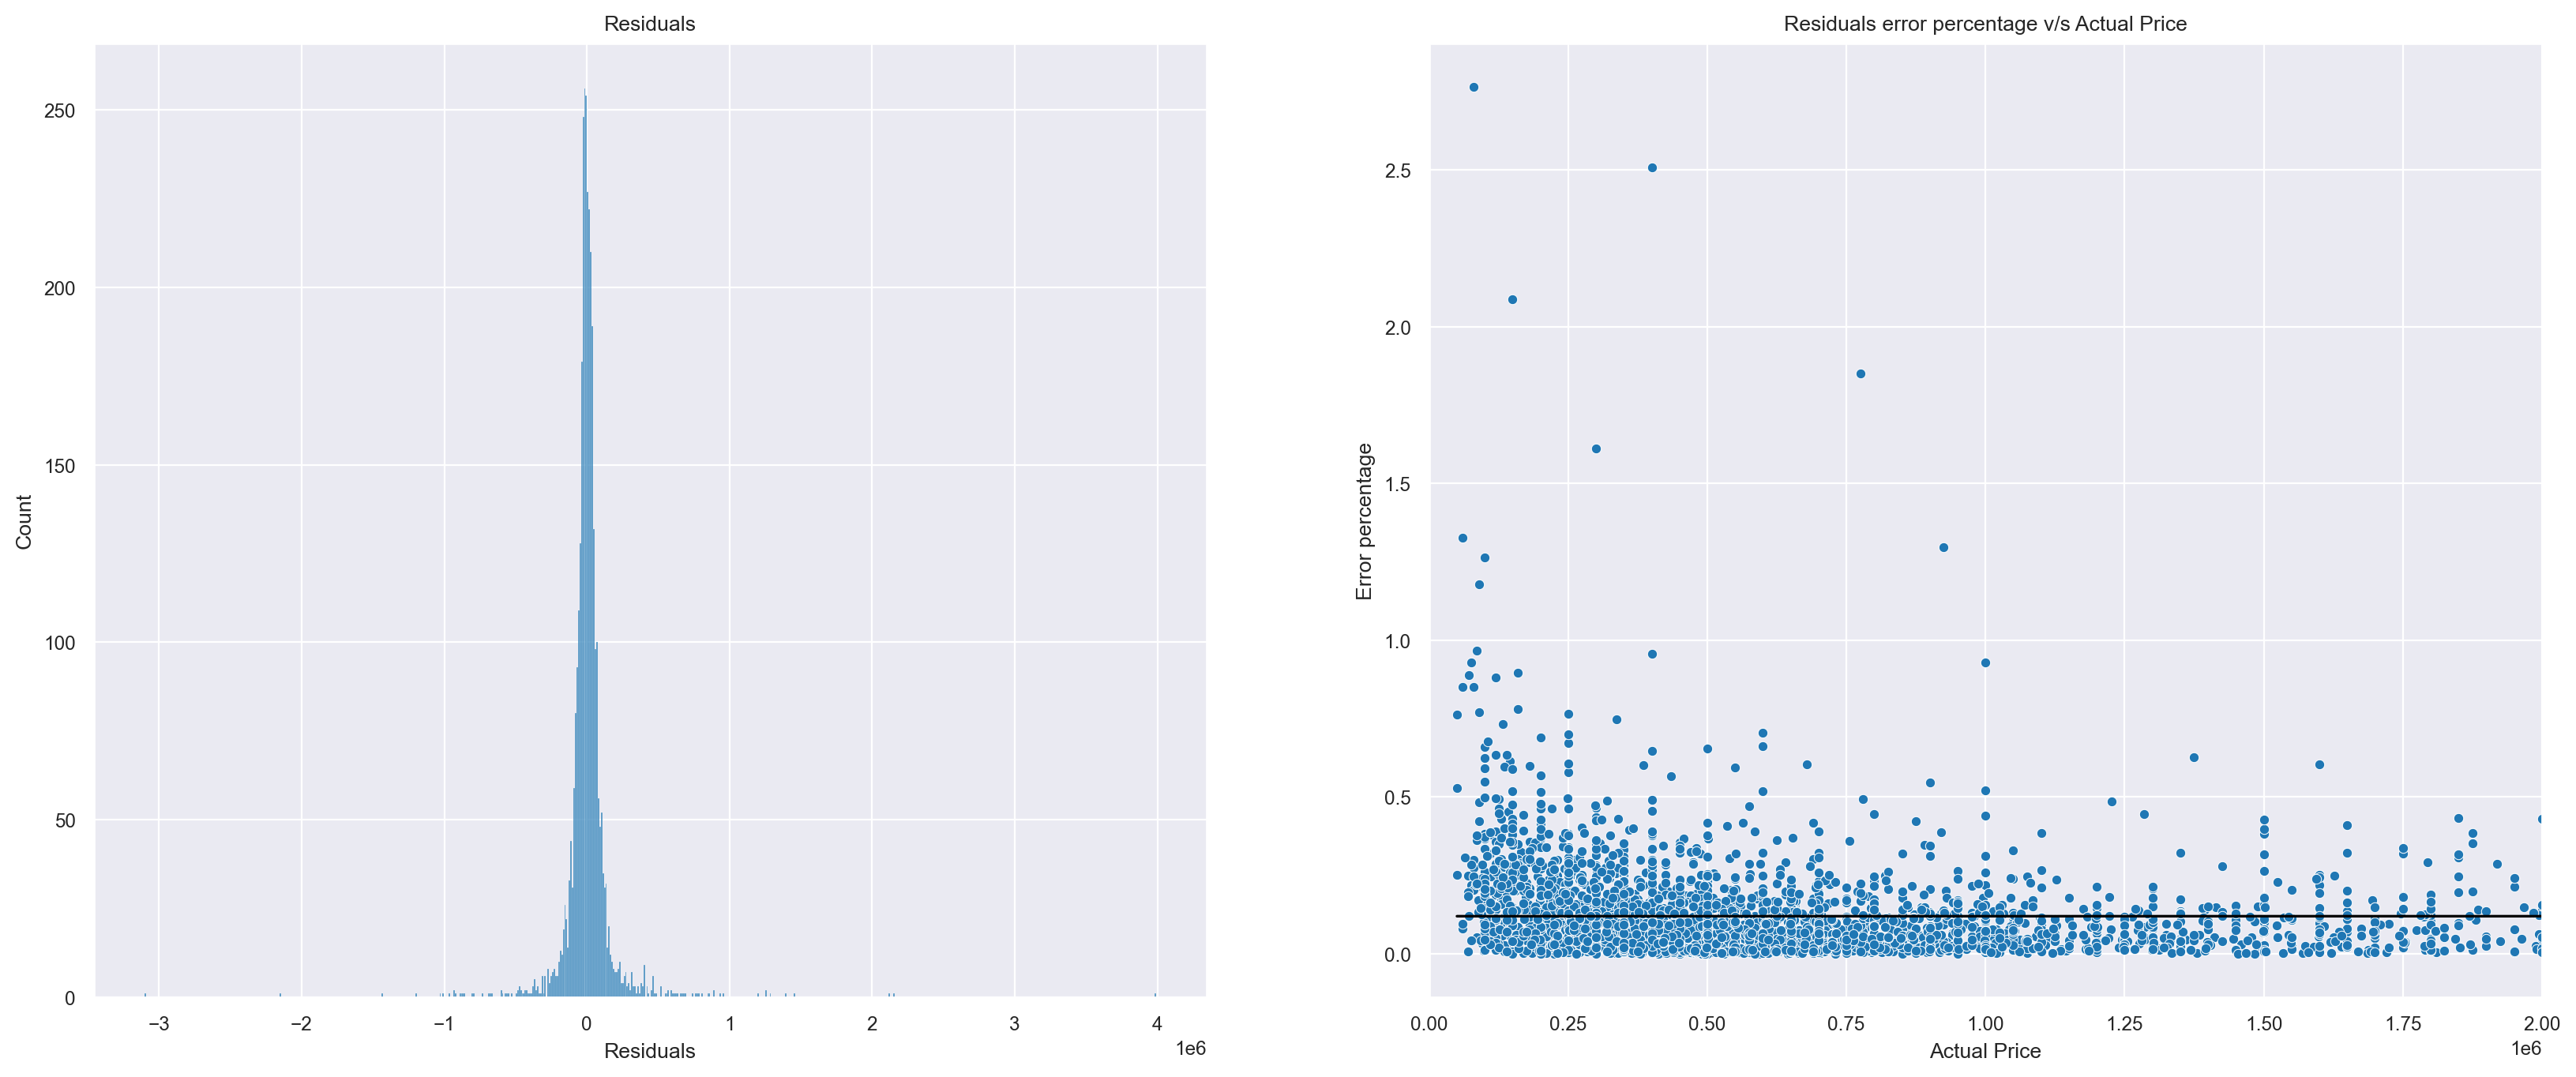

In [251]:
pallete = sns.light_palette("seagreen")
color1 = random.choice(pallete)
color2 = random.choice(pallete)

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(1, 2, figsize=(20, 8))


# Plot the residuals in a histogram in subplot 1
plot1 = sns.histplot(x=(y_test_cat-y_pred), ax=ax[0])
ax[0].set_title('Residuals')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Count')


# Plot the residual along the index in a reg plot in subplot 2
plot2 = sns.scatterplot(x=y_test_cat, y=residuals_percent, s=20)
sns.lineplot(x=y_test, y=0.12, ax=ax[1], color='black')
plot2.set_xlim([0, 2e6])

ax[1].set_title('Residuals error percentage v/s Actual Price')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Error percentage')

---

# Hyperparamter Optimization usin Optuna HyperBand

In [ ]:
import optuna
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def objective(trial, pipeline, X, y):
    param_grid = {
        "tree_method": "hist", # change to gpu_hist if a gpu is available
        "objective": "reg:squarederror",
        "single_precision_histogram": True,
        "importance_type": "gain",
        "n_estimators": trial.suggest_categorical("n_estimators", [1000, 2000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_categorical("max_depth", [5,7,9,11,13,15,17]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "reg_lambda": trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        "random_state": 42,
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipeline['model'].set_params(
            n_jobs= -1,
            **param_grid
        )
        pipeline.fit(X_train, y_train)

        preds = pipeline.predict(X_test)
        cv_scores[idx] = mean_absolute_percentage_error(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
# Define the XGBoost model
xgb_model = xgboost.XGBRegressor()

# Define the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Define the Optuna search algorithm
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, pipeline, X_train, y_train), n_trials=50, timeout=None)

In [ ]:
trial = study.best_trial
best_params = trial.params

best_xgbmodel = xgboost.XGBRegressor(
    **best_params, 
    random_state=42, 
    n_jobs=-1, 
    tree_method="hist", 
    objective="reg:squarederror", 
    single_precision_histogram=True,
    importance_type="gain"
)

# Define the full pipeline
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgbmodel)
])

best_pipeline.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
y_pred = best_pipeline.predict(X_test)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {mape}")
print(f"MAE: {mae}")